# 1. Prepare environment

<ul><li>If you use this notebook first time before restart kernel, install necessary packages before running code:</li></ul>

In [3]:
#Install necessary packages before work
!pip install --user adversarial-robustness-toolbox
!pip install --user texttable

#Model need Keras 2.2.4 and TensorFlow 1.10.0
!pip install keras==2.2.4
!pip install tensorflow==1.10.0

#This might be useful
!pip show keras
!pip show tensorflow

    100% |████████████████████████████████| 204kB 4.5MB/s eta 0:00:01
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
Requirement not upgraded as not directly required: scikit-learn in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
Requirement not upgraded as not directly required: scipy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
Requirement not upgraded as not directly required: setuptools in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from adversarial-robustness-toolbox)
  Running setup.py bdist_wheel for texttable ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/6b/9a/65/2ed3c41a937f0f2780e8a0f0bca

<ul><li>Import libraries and functions:</li></ul>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os
import urllib
import time
import h5py
import keras

from keras.models import load_model

from art import DATA_PATH
from art.utils import load_dataset
from art.classifiers import KerasClassifier
from art.attacks.deepfool import DeepFool
from art.defences.spatial_smoothing import SpatialSmoothing
from art.defences.adversarial_trainer import AdversarialTrainer

from texttable import Texttable

Using TensorFlow backend.


Functions used in this notebook:

In [2]:
#Function draw images from train/test set
def show_images(x_test, _from, _to):
    plt.figure(figsize=(28,28))
    div = _to - _from + 1
    for i, j in zip(range(_from, _to + 1), range(1, div + 1)):
        plt.subplot(28 / div, 5, j)
        plt.imshow(x_test[i].reshape([28,28]))
    plt.show()
    
#Function generate Spatial Smoothing for window size range (1, 28)
def generate_images(x_test):
    for i in range (1,29):
        defence = SpatialSmoothing(window_size=i, channel_index=1)
        x_test_defence = defence(x_test[:number_images])
        print("Window size:", i)
        show_images(x_test_defence, 0, 4)

# 2. Download model

In [10]:
#Create directory and download model to it
data_dir = 'models'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

link = 'https://github.com/IBM/adversarial-robustness-toolbox/raw/master/models/mnist_cnn_original.h5'

filepath = os.path.join(data_dir, os.path.join(link.split('/')[-1]))
if not os.path.isfile(filepath):
    urllib.request.urlretrieve(link, filepath)

!ls -R

.:
models

./models:
mnist_cnn_original.h5


# 3. Load dataset and train with Keras Classifiers

At first, we create necessary directory to avoid permission error:

`PermissionError: [Errno 13] Permission denied: '/tmp/.art'`

In [4]:
print(DATA_PATH)
if not os.path.isdir(DATA_PATH):
    os.mkdir('/home/dsxuser/.art/data')
    
!ls -l /home/dsxuser/.art/

/home/dsxuser/.art/data
total 8
-rw-r----- 1 dsxuser dsxuser   46 Jan 20 13:47 config.json
drwxr-x--- 2 dsxuser dsxuser 4096 Jan 20 13:58 data


Second, check which Keras version was used to train `h5` model and compare with our Keras version:

In [5]:
f = h5py.File(filepath, 'r')
print(f.attrs.get('keras_version'))

print(keras.__version__)

b'2.2.2'
2.2.4


Load dataset, model and dataset description:

Dataset contains 60000 training 28 x 28 pixel images and 10000 test images. Pixel values were normalized to [0,1] range.


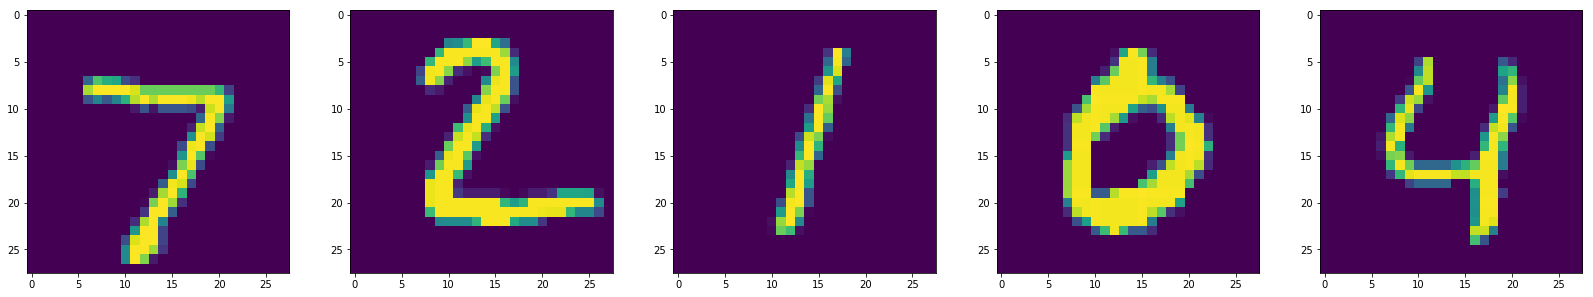

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

In [6]:
number_images = 1000
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')
classifier_model = load_model(filepath, compile=True)
classifier = KerasClassifier(model=classifier_model, clip_values=(0, 1))

print("Dataset contains", len(x_train), "training", len(x_train[0]), "x", len(x_train[0]), "pixel images and", len(x_test), "test images. Pixel values were normalized to [0,1] range.")
show_images(x_test, 0, 4)
classifier_model.summary()

#Accuracy of model
start = time.time()
x_test_pred = np.argmax(classifier.predict(x_test[:number_images]), axis=1)
correct_pred = np.sum(x_test_pred == np.argmax(y_test[:number_images], axis=1))

print("Original test data (first", number_images, "images):")
t = Texttable()
t.add_rows([['True', 'False'], [correct_pred, number_images - correct_pred]])
print(t.draw())

acc = round(correct_pred/number_images*100, 4)
print("Accuracy: ", acc, "%", sep='')

end = time.time()
print("\nPrediction time:", int(end - start), "seconds")

# 4. Attack

Generate DeepFool attack...
Attack generated

Generation time: 599 seconds


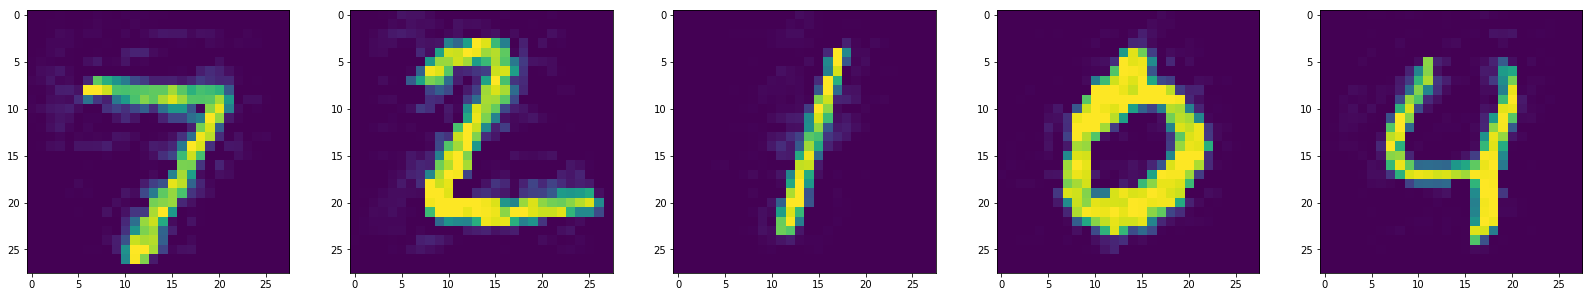

Attacked test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 95   | 905   |
+------+-------+
Accuracy: 9.5%

Prediction time: 0 seconds


In [7]:
print("Generate DeepFool attack...")

start = time.time()
attack = DeepFool(classifier)
x_test_attack = attack.generate(x_test[:number_images])
print("Attack generated")
end = time.time()
print("\nGeneration time:", int(end - start), "seconds")
show_images(x_test_attack, 0, 4)

start = time.time()
x_test_attack_pred = np.argmax(classifier.predict(x_test_attack), axis=1)
correct_attack_pred = np.sum(x_test_attack_pred == np.argmax(y_test[:number_images]))

print("Attacked test data (first", number_images, "images):")

t = Texttable()
t.add_rows([['True', 'False'], [correct_attack_pred, number_images - correct_attack_pred]])
print(t.draw())

acc = round(correct_attack_pred/number_images*100, 4)
print("Accuracy: ", acc, "%", sep='')

end = time.time()
print("\nPrediction time:", int(end - start), "seconds")

# 5. Defence
## 5.1 Spatial Smoothing
Check how this method smoothes images

Window size: 1


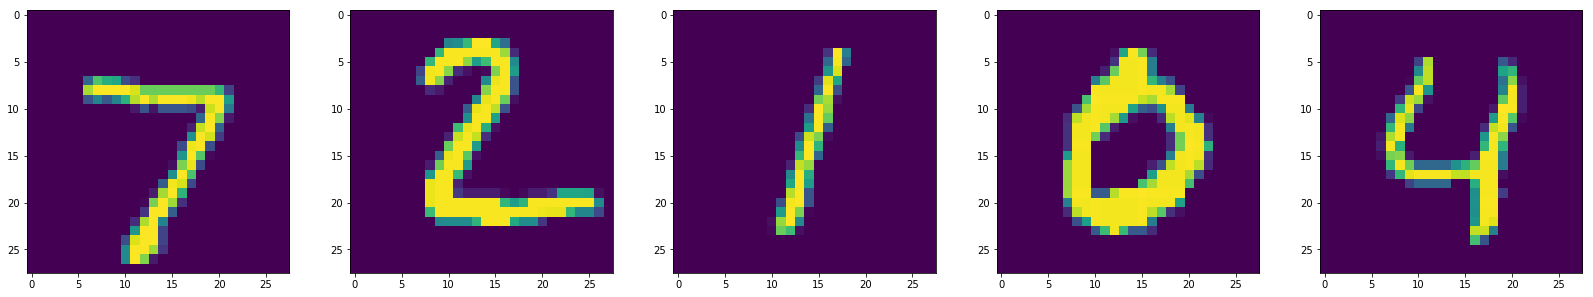

Window size: 2


Window size: 3


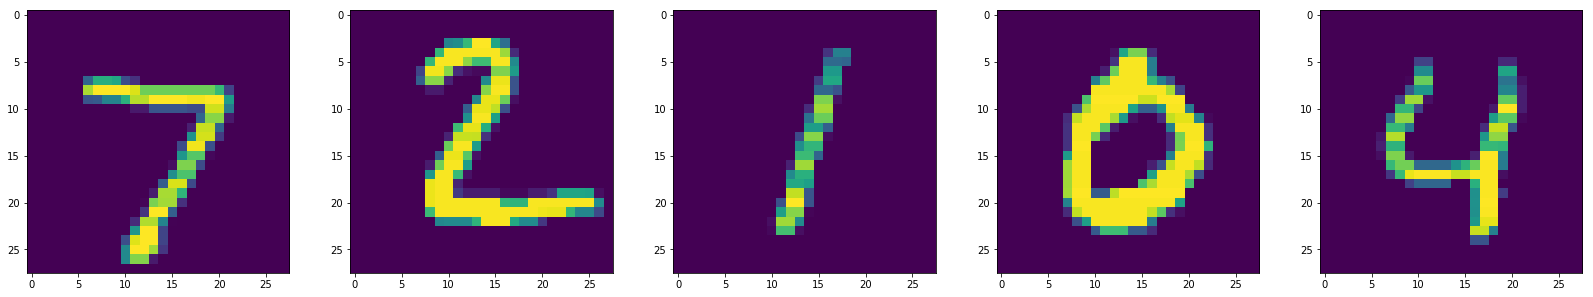

Window size: 4


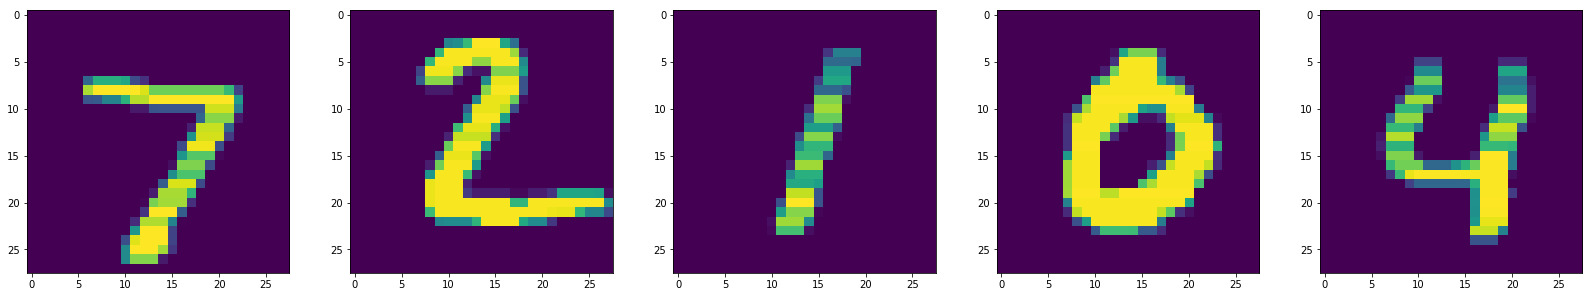

Window size: 5


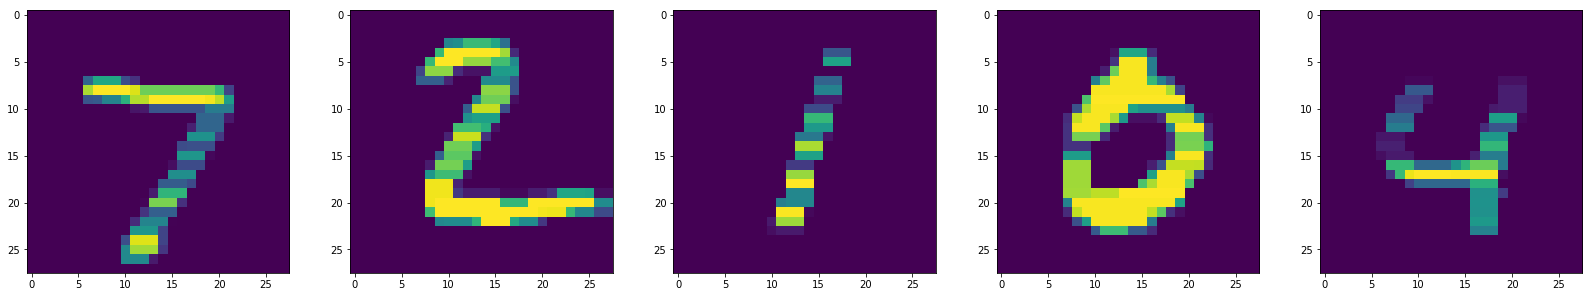

Window size: 6


Window size: 7


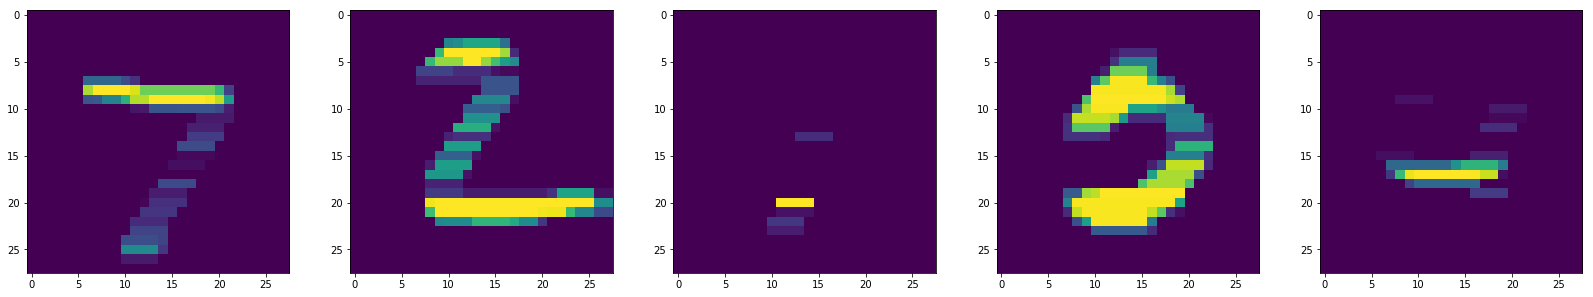

Window size: 8


Window size: 9


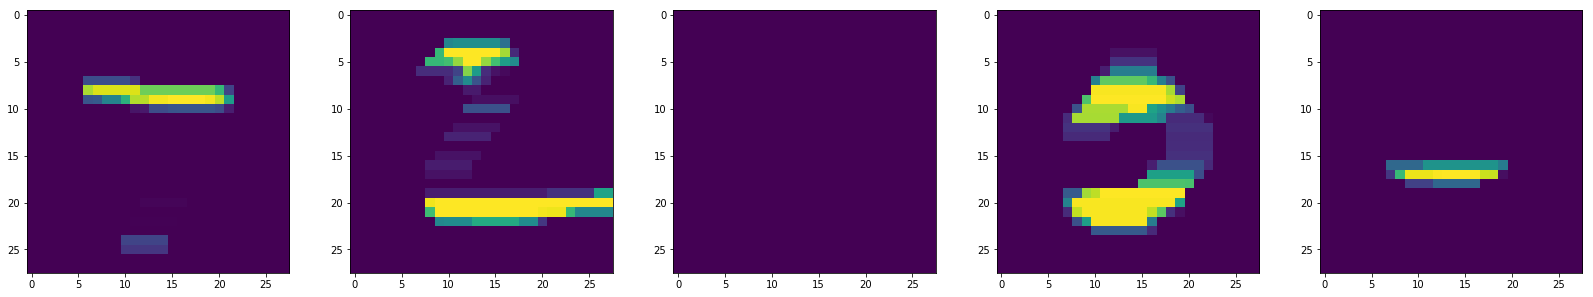

Window size: 10


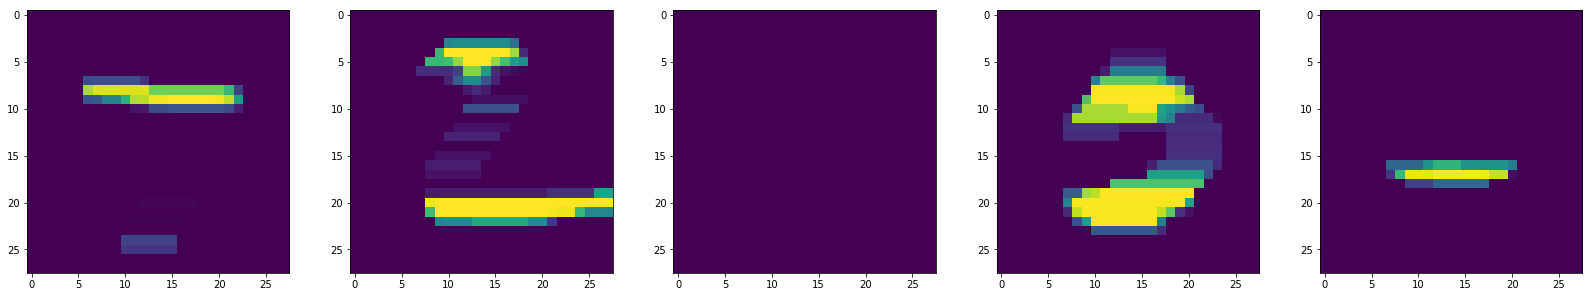

Window size: 11


Window size: 12


Window size: 13


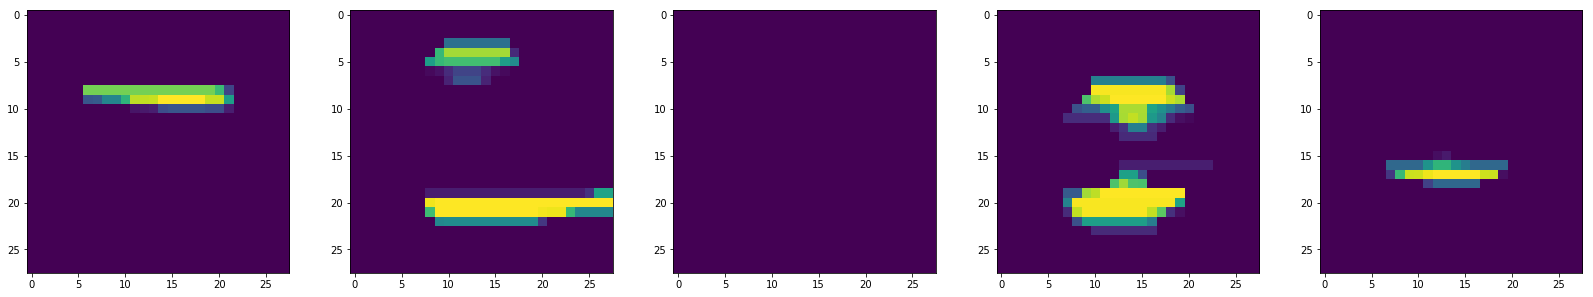

Window size: 14


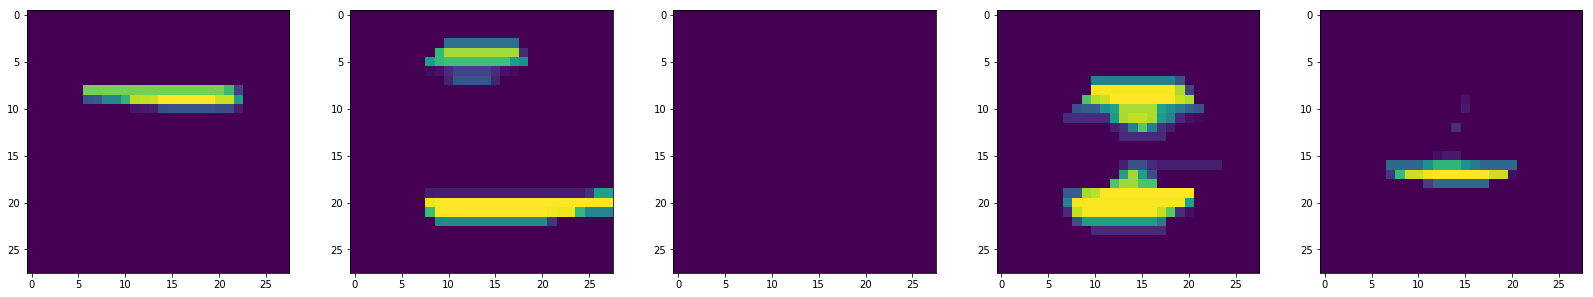

Window size: 15


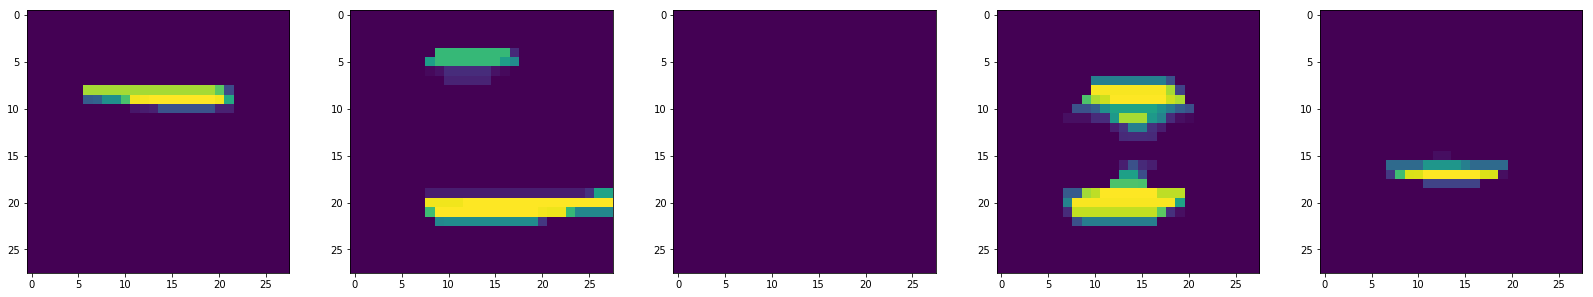

Window size: 16


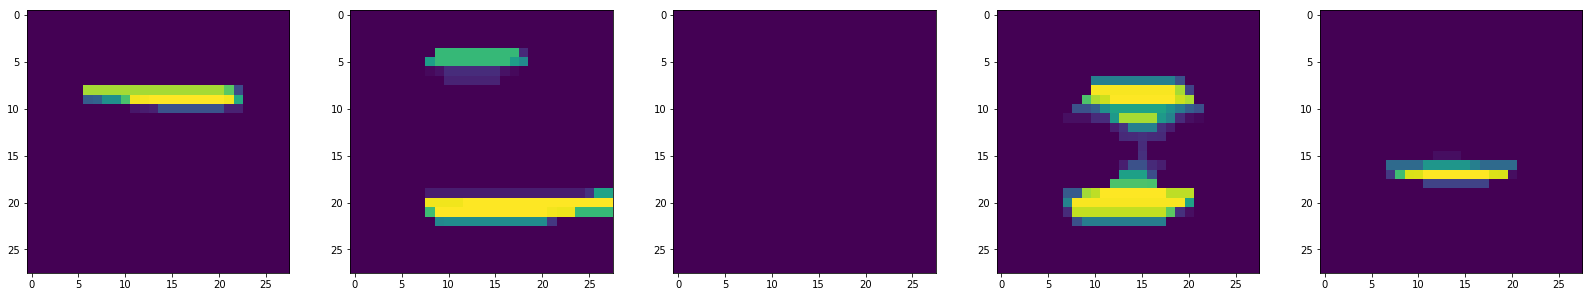

Window size: 17


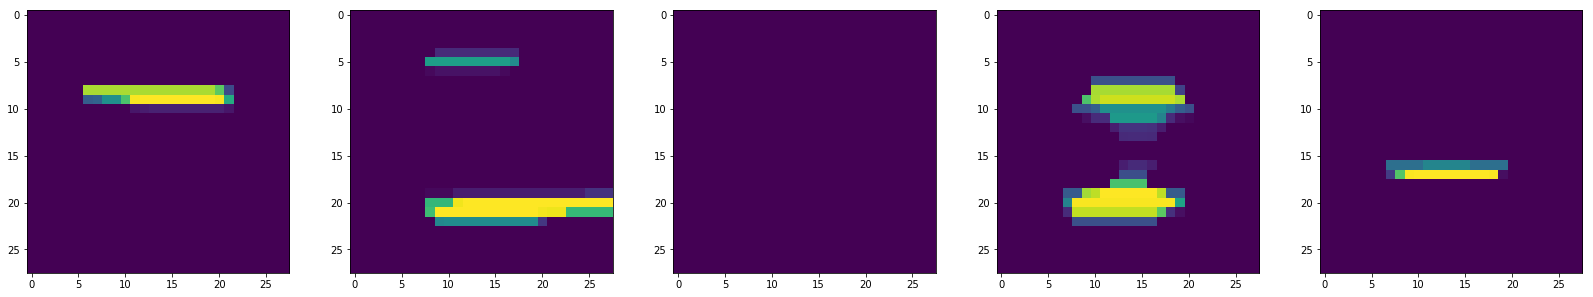

Window size: 18


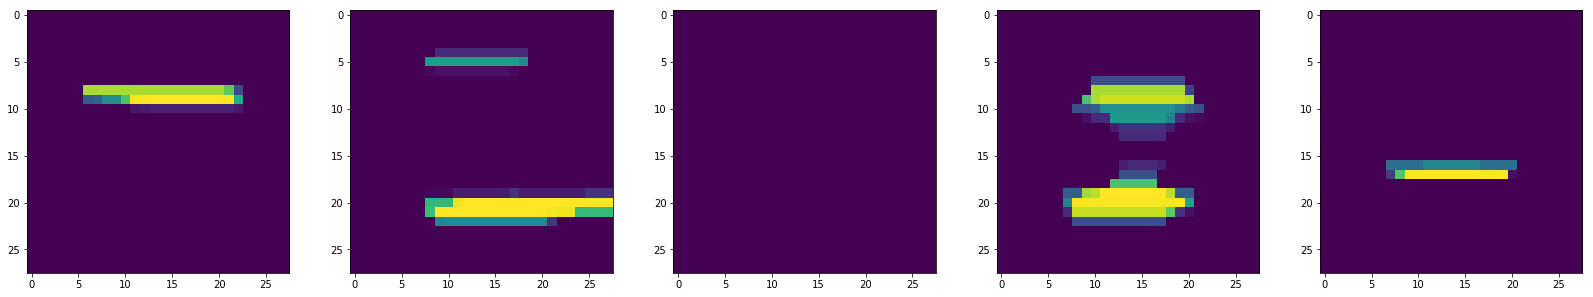

Window size: 19


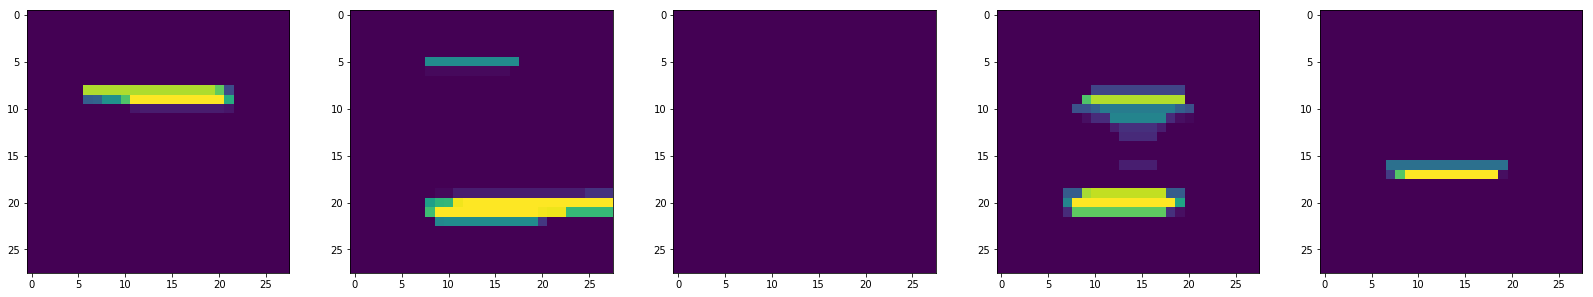

Window size: 20


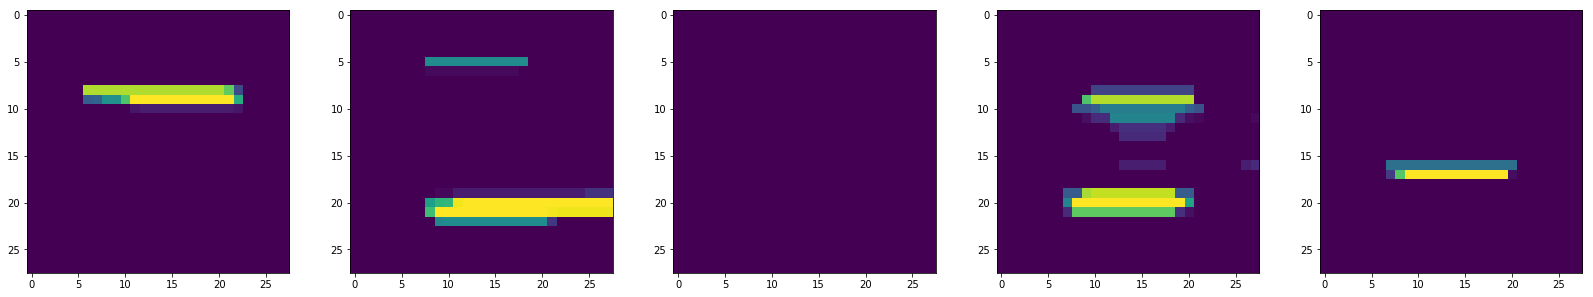

Window size: 21


Window size: 22


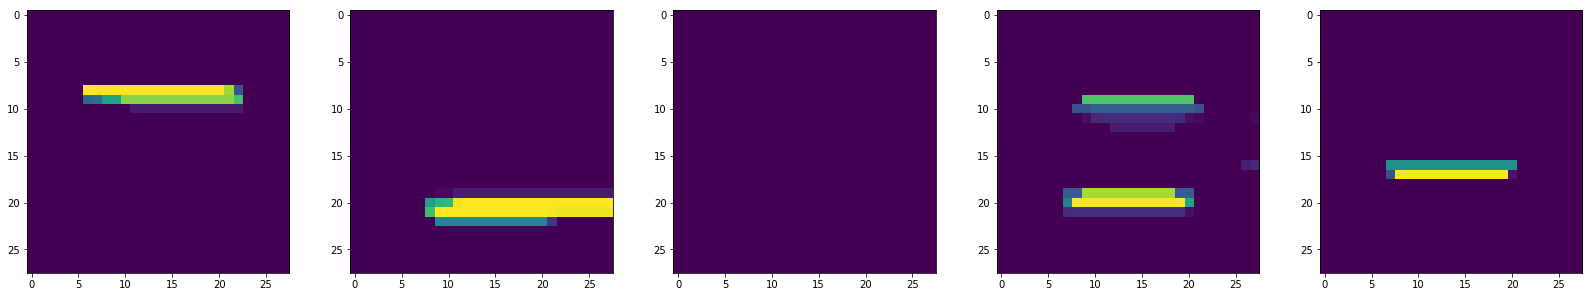

Window size: 23


Window size: 24


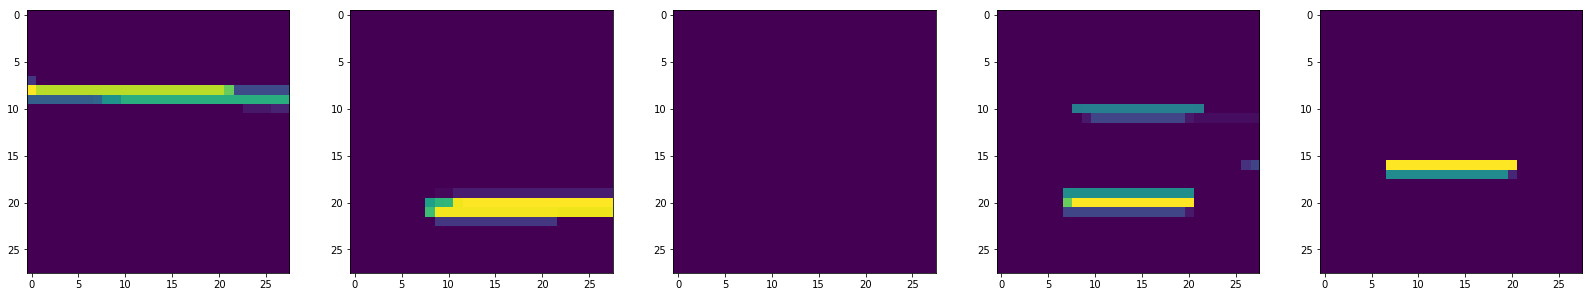

Window size: 25


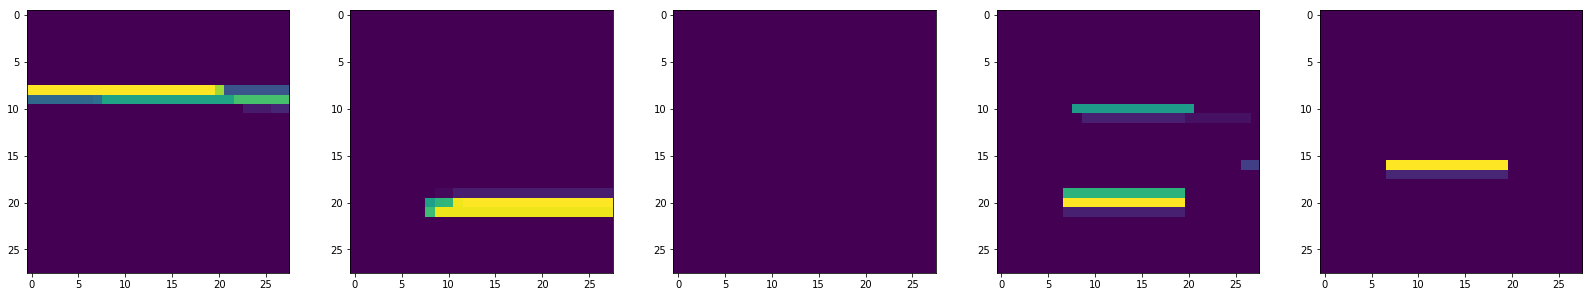

Window size: 26


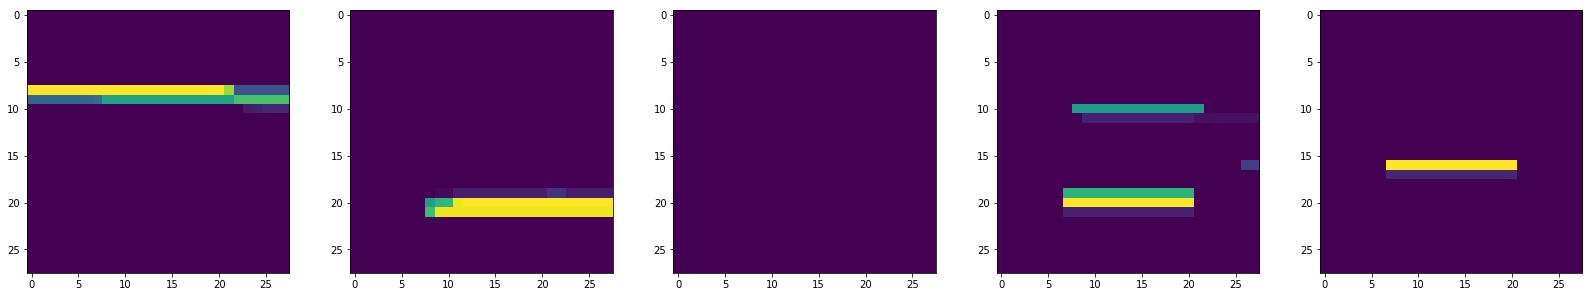

Window size: 27


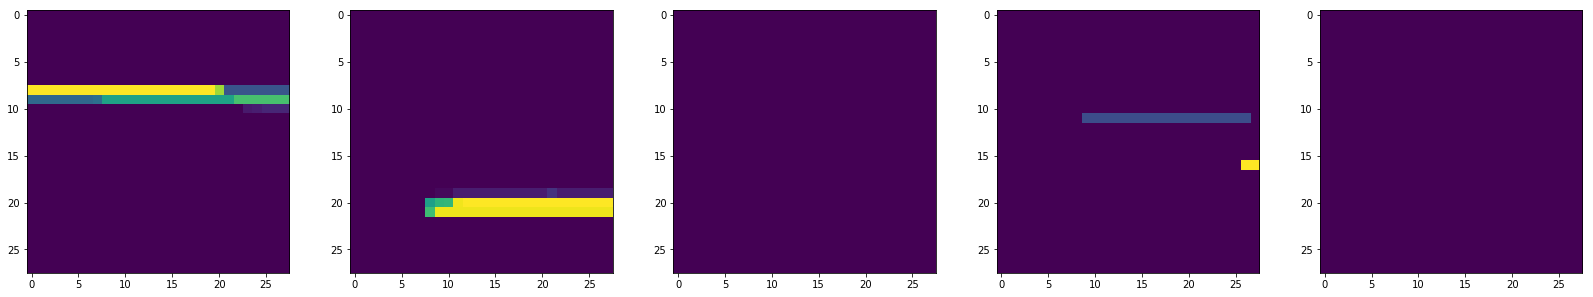

Window size: 28


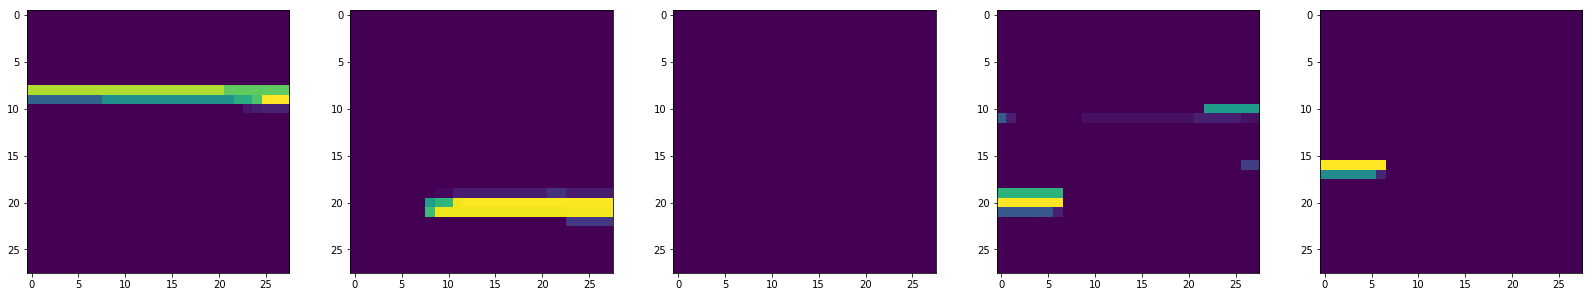

In [17]:
generate_images(x_test)

Window size between 2 and 6 does not damage images. Above 6, the digits are becoming unreadable.

### 5.1.1 Attack the defended images
Test accuracy between the best parameter of window sizes and compare classifiers:

In [62]:
number_images = 100
ws_list = []
acc_attack_list = []
acc_defend_list = []
attack = DeepFool(classifier)
for i in range(2,29):
    print("-------------------------------------------------")
    print("Window size:", i)
    #Defence
    defence = SpatialSmoothing(window_size=i, channel_index=1)
    x_test_defence = defence(x_test[:number_images])

    #Attack
    start = time.time()
    x_test_defence_attack = attack.generate(x_test_defence)
    end = time.time()
    print("\nTime:", int(end - start), "seconds")

    #Prediction
    start = time.time()
    x_test_defence_attack_pred = np.argmax(classifier.predict(x_test_defence_attack), axis=1)
    correct_defence_attack_pred = np.sum(x_test_defence_attack_pred == np.argmax(y_test[:number_images]))
    
    x_test_defence_pred = np.argmax(classifier.predict(x_test_defence), axis=1)
    correct_defence_pred = np.sum(x_test_defence_pred == np.argmax(y_test[:number_images]))

    print("Attacked test data (first", number_images, "images):")
    t = Texttable()
    t.add_rows([['True', 'False'], [correct_defence_attack_pred, number_images - correct_defence_attack_pred]])
    print(t.draw())
    acc_attack = round(correct_defence_attack_pred/number_images*100, 4)
    print("Accuracy: ", acc_attack, "%", sep='')
    
    print("Defended test data (first", number_images, "images):")
    t = Texttable()
    t.add_rows([['True', 'False'], [correct_defence_pred, number_images - correct_defence_pred]])
    print(t.draw())
    acc_defend = round(correct_defence_pred/number_images*100, 4)
    print("Accuracy: ", acc_defend, "%", sep='')
    
    ws_list.append(i)
    acc_attack_list.append(acc_attack)
    acc_defend_list.append(acc_defend)

    end = time.time()
    print("\nTime:", int(end - start), "seconds")

-------------------------------------------------
Window size: 2

Time: 55 seconds
Attacked test data (first 100 images):
+------+-------+
| True | False |
+======+=======+
| 9    | 91    |
+------+-------+
Accuracy: 9.0%
Defended test data (first 100 images):
+------+-------+
| True | False |
+======+=======+
| 15   | 85    |
+------+-------+
Accuracy: 15.0%

Time: 0 seconds
-------------------------------------------------
Window size: 3

Time: 51 seconds
Attacked test data (first 100 images):
+------+-------+
| True | False |
+======+=======+
| 11   | 89    |
+------+-------+
Accuracy: 11.0%
Defended test data (first 100 images):
+------+-------+
| True | False |
+======+=======+
| 15   | 85    |
+------+-------+
Accuracy: 15.0%

Time: 0 seconds
-------------------------------------------------
Window size: 4

Time: 49 seconds
Attacked test data (first 100 images):
+------+-------+
| True | False |
+======+=======+
| 9    | 91    |
+------+-------+
Accuracy: 9.0%
Defended test data 

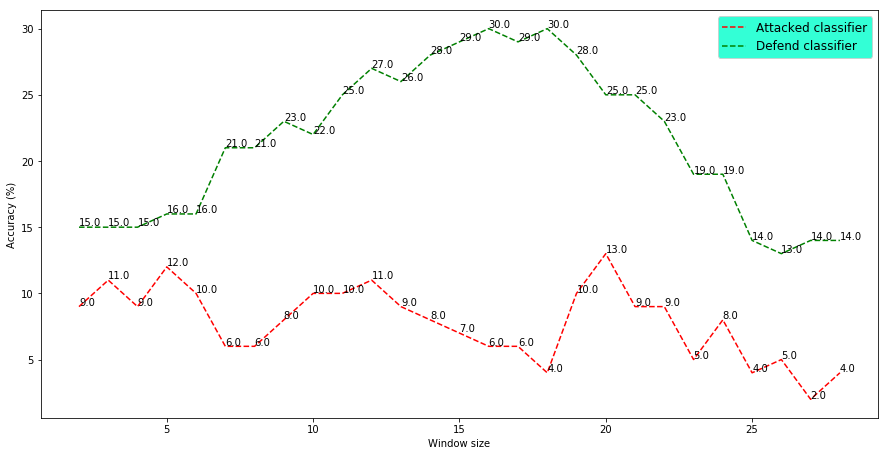

In [94]:
fig, ax = plt.subplots(figsize=(15,7.5))
ax.plot(np.array(ws_list), np.array(acc_attack_list), 'r--', label='Attacked classifier')
ax.plot(np.array(ws_list), np.array(acc_defend_list), 'g--', label='Defend classifier')

for i,j in zip(ws_list,acc_attack_list):
    ax.annotate(str(j),xy=(i,j+0.1))
for i,j in zip(ws_list,acc_defend_list):
    ax.annotate(str(j),xy=(i,j+0.1))

legend = ax.legend(shadow=False, fontsize='large', bbox_to_anchor=(1, 1))
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Window size')
plt.ylabel('Accuracy (%)')
plt.show()

For `window_size=20` is the best accuracy attacked classifier: 13.0%, but image is undreadable. In range [2;6] for `window_size=5` is the best accuracy attacked classifier: 12.0%. Generate `SpatialSmoothing` with this values for 1000 images:

In [11]:
number_images = 1000
defence = SpatialSmoothing(window_size=5, channel_index=1)
x_test_defence = defence(x_test[:number_images])
print("Defence generated")

print("Generate DeepFool attack on defence samples...")
start = time.time()
x_test_defence_attack = attack.generate(x_test_defence)
print("Attack generated")
end = time.time()
print("\nTime:", int(end - start), "seconds")

start = time.time()
x_test_defence_attack_pred = np.argmax(classifier.predict(x_test_defence_attack), axis=1)
correct_defence_attack_pred = np.sum(x_test_defence_attack_pred == np.argmax(y_test[:number_images]))

print("Attacked test data (first", number_images, "images):")

t = Texttable()
t.add_rows([['True', 'False'], [correct_defence_attack_pred, number_images - correct_defence_attack_pred]])
print(t.draw())

acc = round(correct_defence_attack_pred/number_images*100, 4)
print("Accuracy: ", acc, "%", sep='')

end = time.time()
print("\nTime:", int(end - start), "seconds")

Defence generated
Generate DeepFool attack on defence samples...
Attack generated

Time: 511 seconds
Attacked test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 97   | 903   |
+------+-------+
Accuracy: 9.7%

Time: 1 seconds


In [103]:
number_images = 1000
defence = SpatialSmoothing(window_size=20, channel_index=1)
x_test_defence = defence(x_test[:number_images])
print("Defence generated")

print("Generate DeepFool attack on defence samples...")
start = time.time()
x_test_defence_attack = attack.generate(x_test_defence)
print("Attack generated")
end = time.time()
print("\nTime:", int(end - start), "seconds")

start = time.time()
x_test_defence_attack_pred = np.argmax(classifier.predict(x_test_defence_attack), axis=1)
nb_correct_defence_attack_pred = np.sum(x_test_defence_attack_pred == np.argmax(y_test[:number_images]))

print("Attacked test data (first", number_images, "images):")

t = Texttable()
t.add_rows([['True', 'False'], [nb_correct_defence_attack_pred, number_images - nb_correct_defence_attack_pred]])
print(t.draw())

acc = round(nb_correct_defence_attack_pred/number_images*100, 4)
print("Accuracy: ", acc, "%", sep='')

end = time.time()
print("\nTime:", int(end - start), "seconds")

Defence generated
Generate DeepFool attack on defence samples...
Attack generated

Time: 533 seconds
Attacked test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 132  | 868   |
+------+-------+
Accuracy: 13.2%

Time: 0 seconds


### 5.1.2 Defend the attacked images
Check how accuracy change after defending the attacked images:

In [105]:
number_images = 1000
ws_list = []
acc_list = []
for i in range(1,29):
    print("Window size: ", i)
    start = time.time()
    defence = SpatialSmoothing(window_size=i, channel_index=1)
    x_test_attack_defence = defence(x_test_attack[:number_images])
    print("Defence generated")
    end = time.time()
    print("\nTime:", int(end - start), "seconds")

    start = time.time()
    x_test_attack_defence_pred = np.argmax(classifier.predict(x_test_attack_defence), axis=1)
    nb_correct_attack_defence_pred = np.sum(x_test_attack_defence_pred == np.argmax(y_test[:number_images]))

    print("Defended test data (first", number_images, "images):")

    t = Texttable()
    t.add_rows([['True', 'False'], [nb_correct_attack_defence_pred, number_images - nb_correct_attack_defence_pred]])
    print(t.draw())

    acc = round(nb_correct_attack_defence_pred/number_images*100, 4)
    print("Accuracy: ", acc, "%", sep='')
    ws_list.append(i)
    acc_list.append(acc)

    end = time.time()
    print("\nTime:", int(end - start), "seconds")

Window size:  1
Defence generated

Time: 0 seconds
Defended test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 95   | 905   |
+------+-------+
Accuracy: 9.5%

Time: 0 seconds
Window size:  2
Defence generated

Time: 0 seconds
Defended test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 100  | 900   |
+------+-------+
Accuracy: 10.0%

Time: 0 seconds
Window size:  3
Defence generated

Time: 0 seconds
Defended test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 99   | 901   |
+------+-------+
Accuracy: 9.9%

Time: 1 seconds
Window size:  4
Defence generated

Time: 0 seconds
Defended test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 103  | 897   |
+------+-------+
Accuracy: 10.3%

Time: 0 seconds
Window size:  5
Defence generated

Time: 0 seconds
Defended test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 126  | 874   |
+------

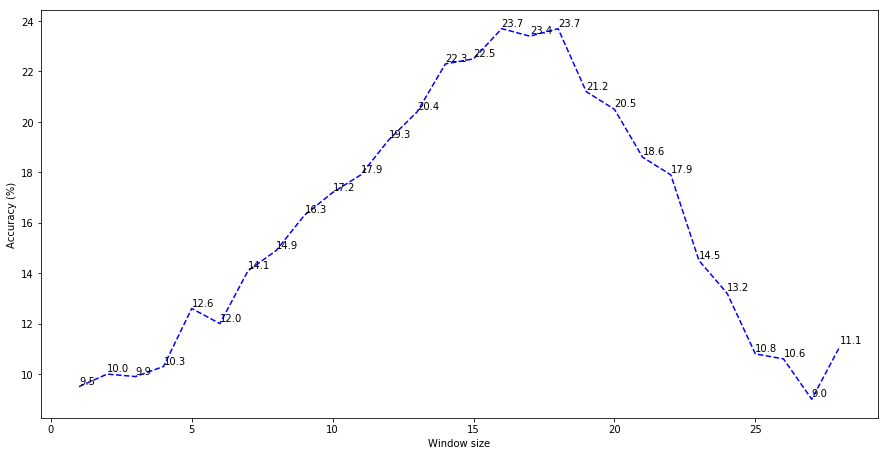

In [106]:
fig, ax = plt.subplots(figsize=(15,7.5))
ax.plot(np.array(ws_list), np.array(acc_list), 'b--')

for i,j in zip(ws_list,acc_list):
    ax.annotate(str(j),xy=(i,j+0.1))

plt.xlabel('Window size')
plt.ylabel('Accuracy (%)')
plt.show()

Window size 16 and 18 reached above 23%. How it look on images:

Window size: 1


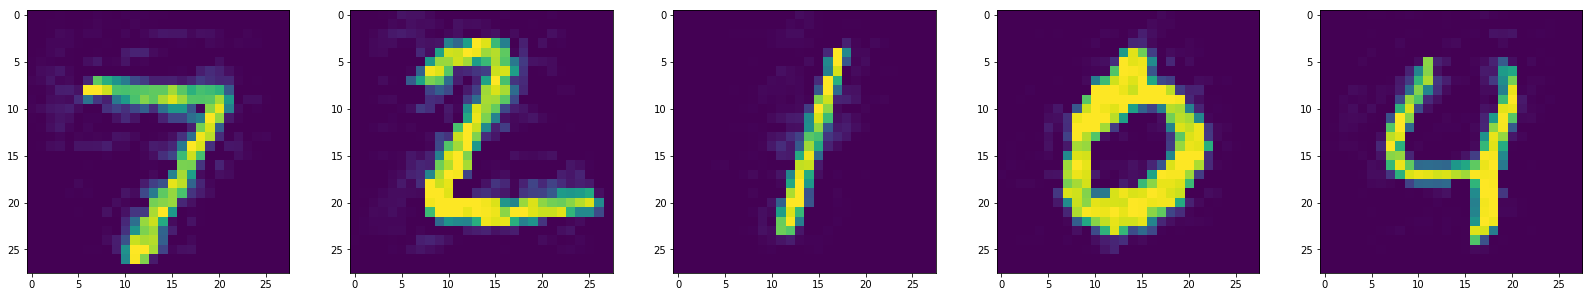

Window size: 2


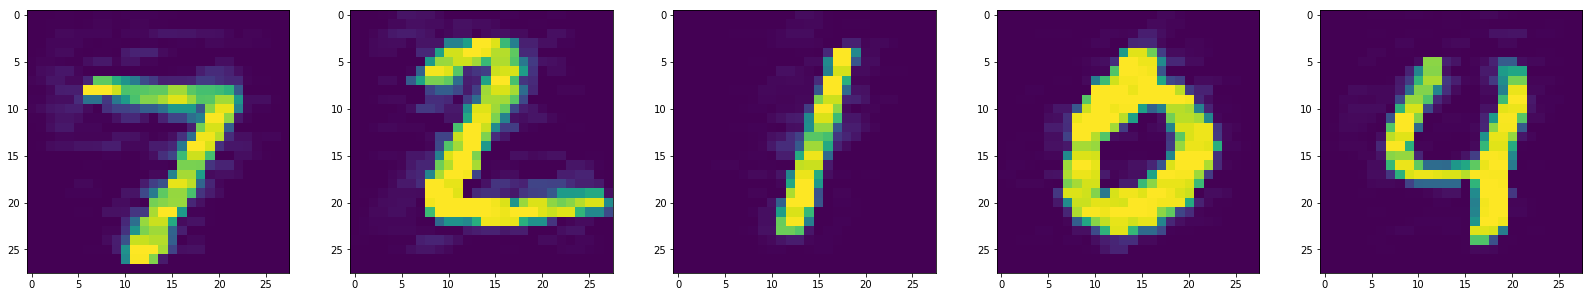

Window size: 3


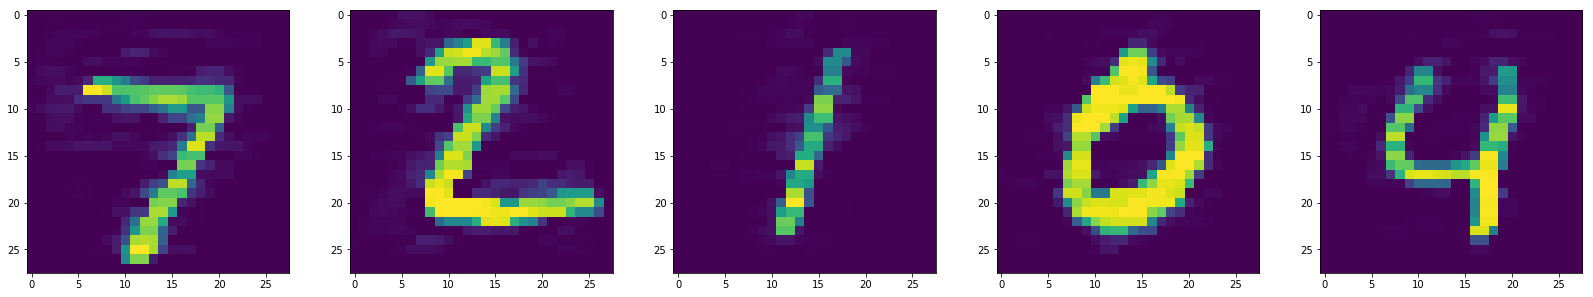

Window size: 4


Window size: 5


Window size: 6


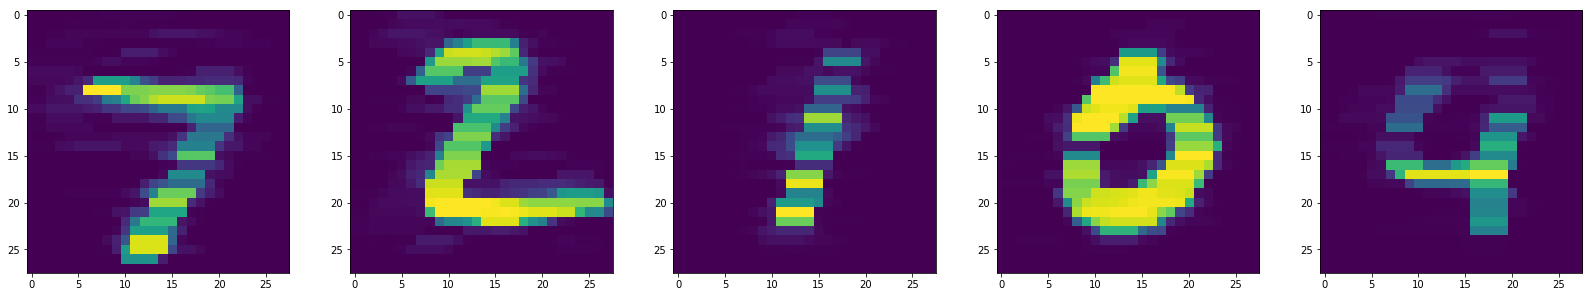

Window size: 7


Window size: 8


Window size: 9


Window size: 10


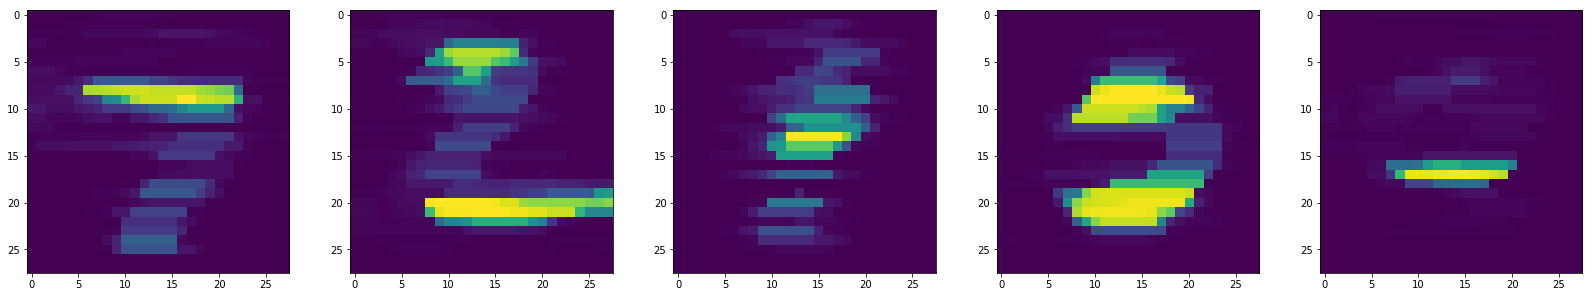

Window size: 11


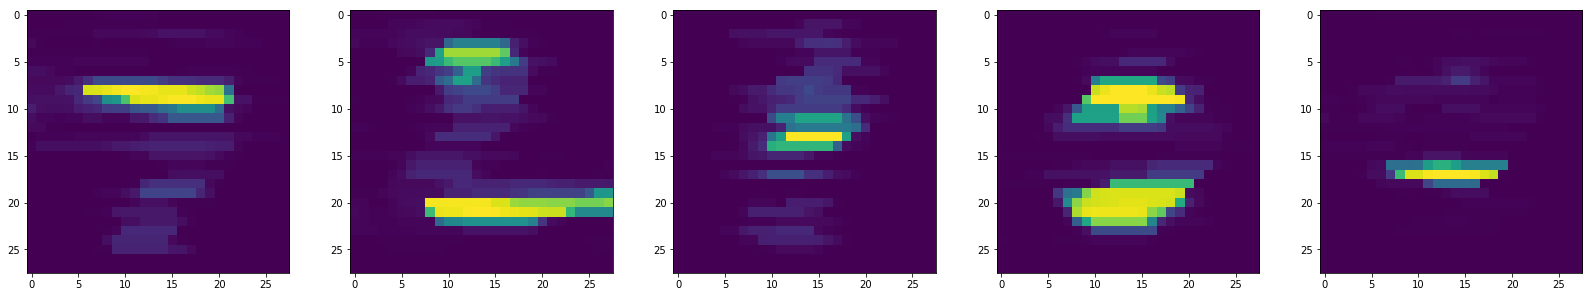

Window size: 12


Window size: 13


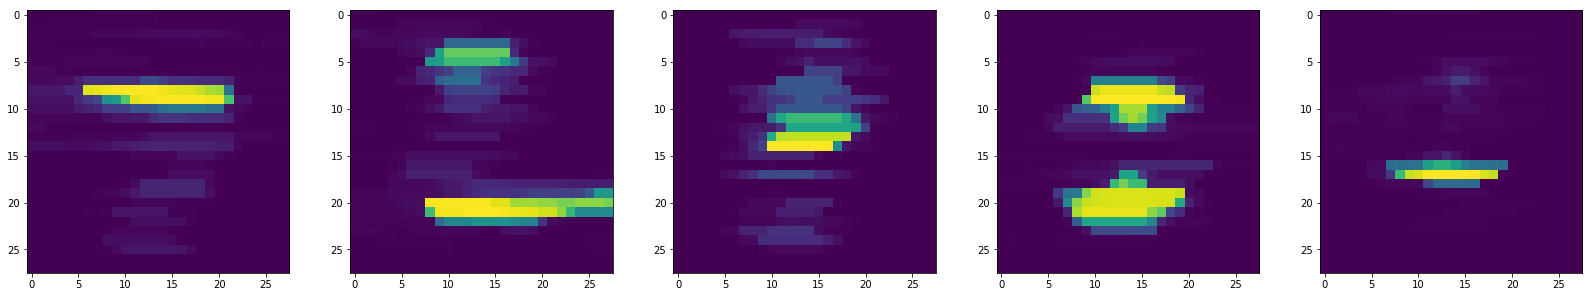

Window size: 14


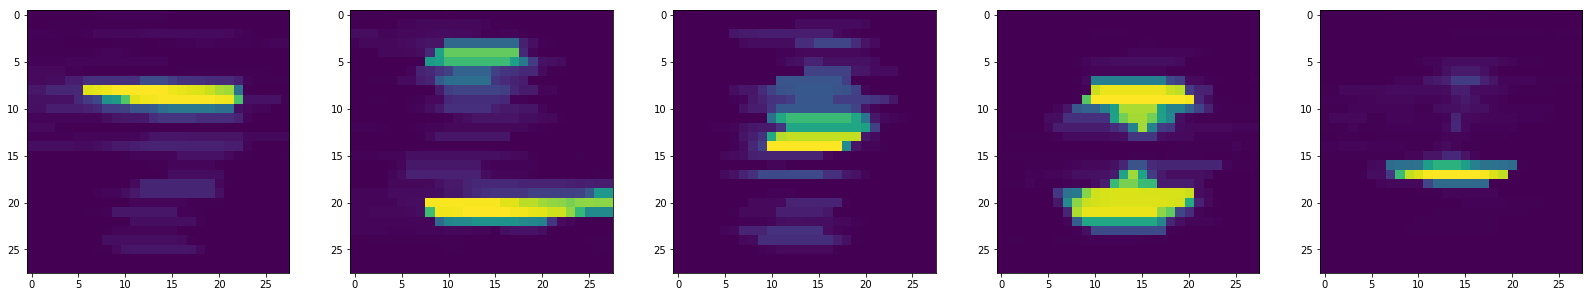

Window size: 15


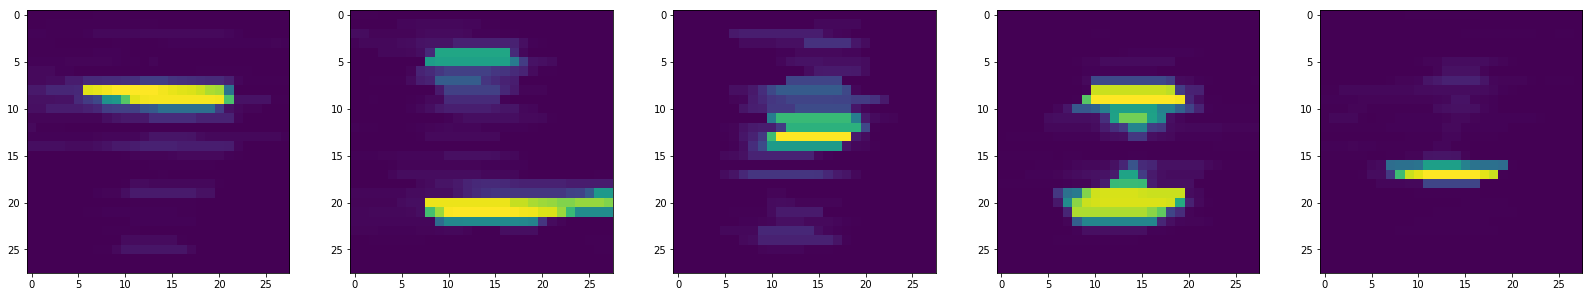

Window size: 16


Window size: 17


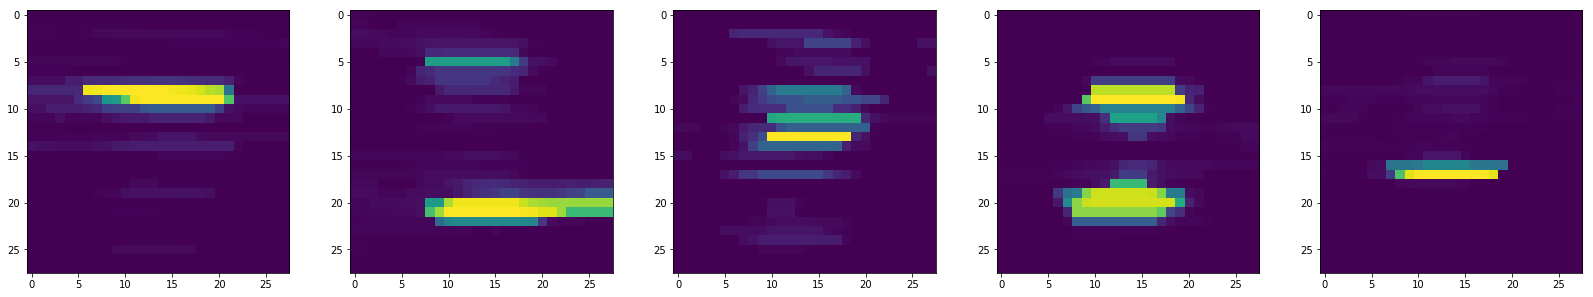

Window size: 18


Window size: 19


Window size: 20


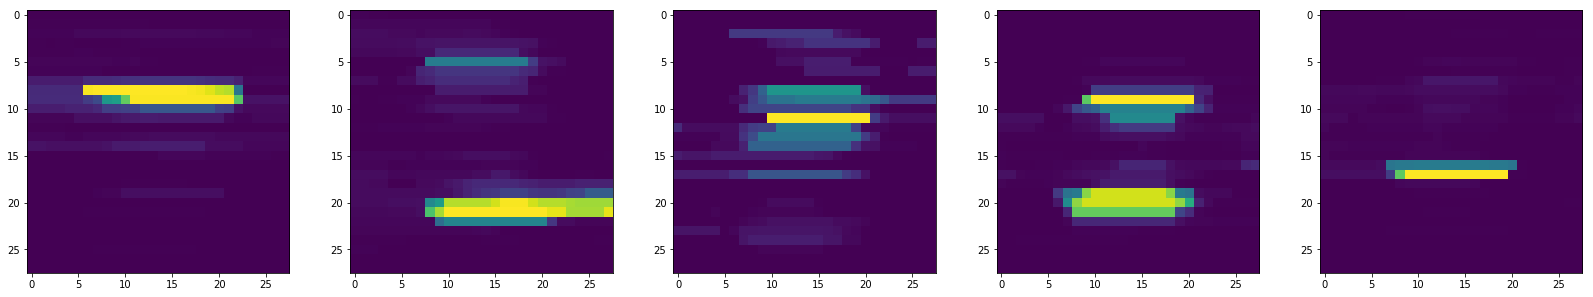

Window size: 21


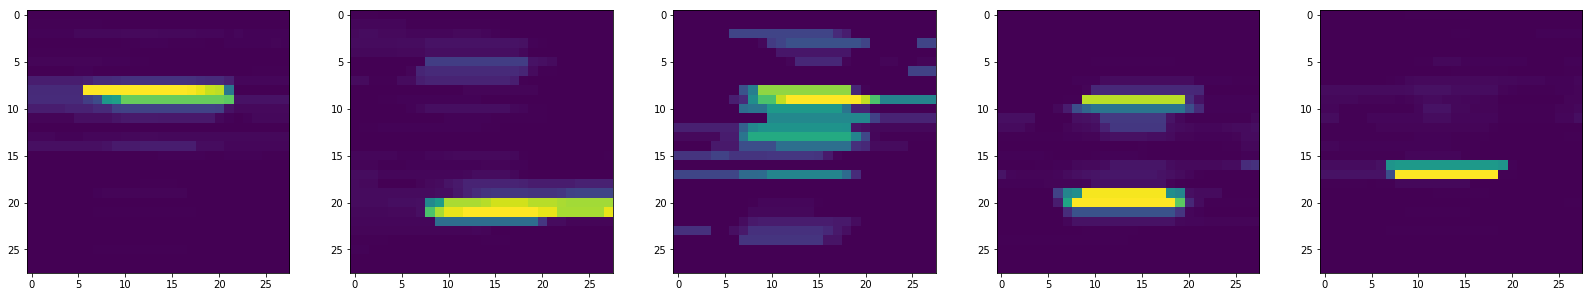

Window size: 22


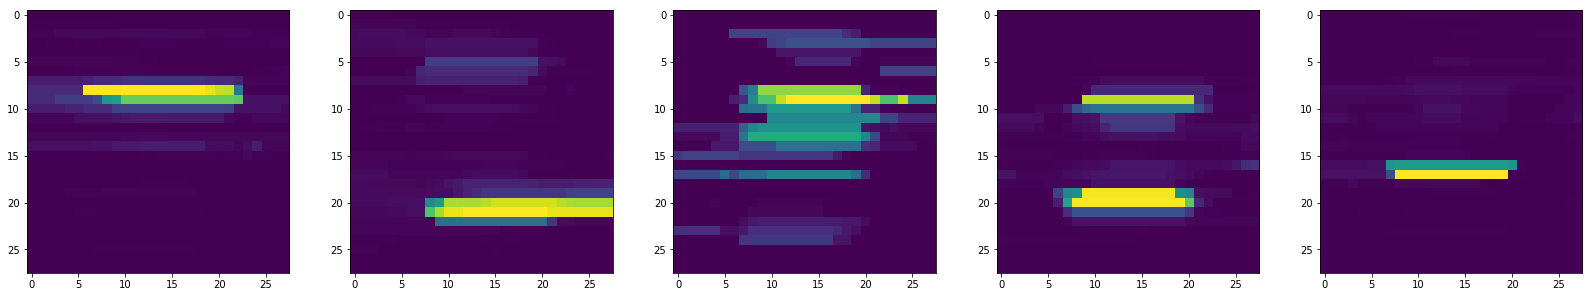

Window size: 23


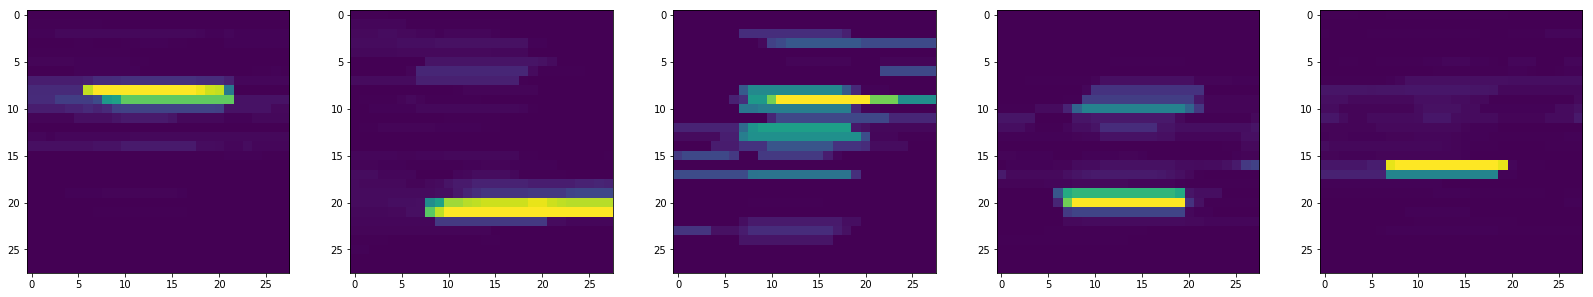

Window size: 24


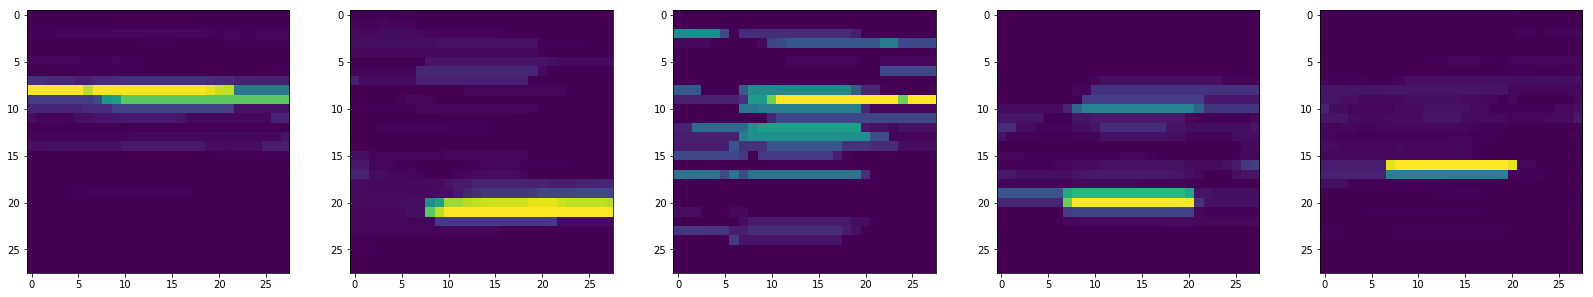

Window size: 25


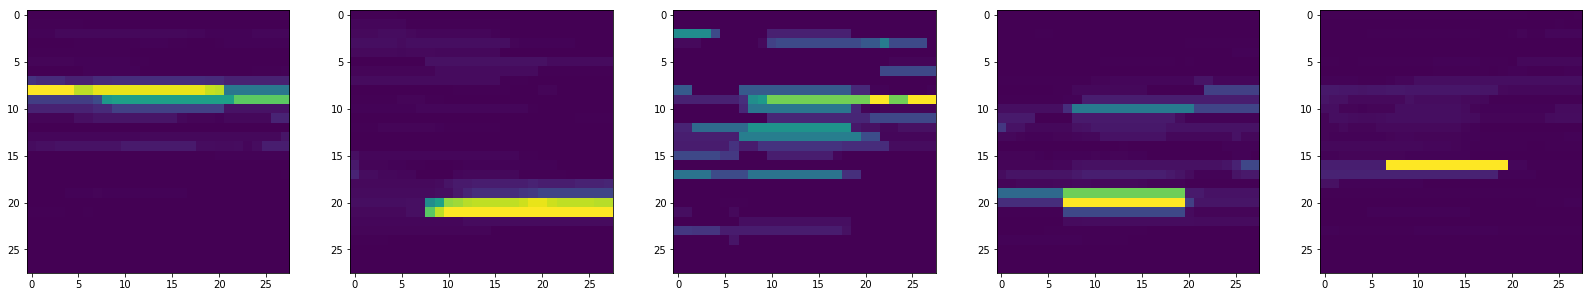

Window size: 26


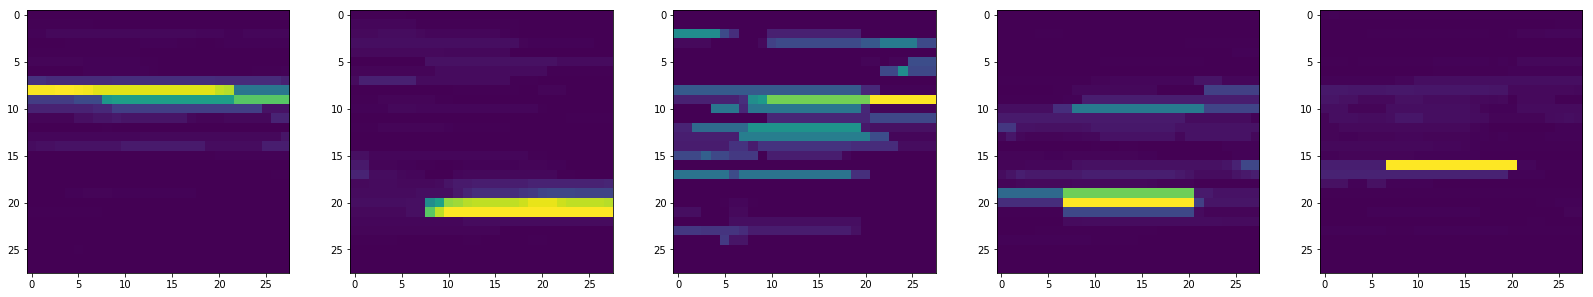

Window size: 27


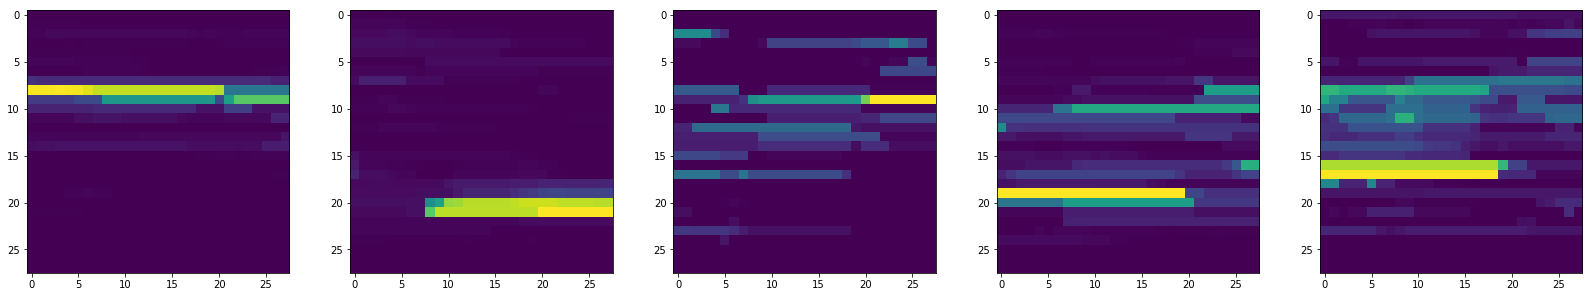

Window size: 28


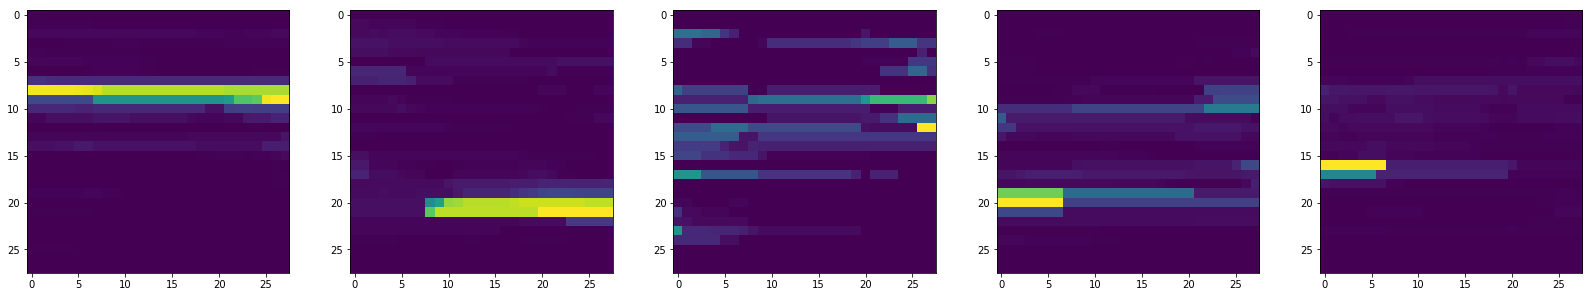

In [107]:
generate_images(x_test_attack)

## 5.2 Adversarial Training
This method need generate attack on train set. Because this process could take ~19 hours, we cutted train set to 1000 samples.

In [12]:
number_images = 100
attack = DeepFool(classifier)
defence = AdversarialTrainer(classifier, attack)
start = time.time()
defence.fit(x_train[:6000], y_train[:6000])
fit = defence.predict(x_test[:number_images])

x_test_attack_pred = np.argmax(fit, axis=1)
correct_attack_pred = np.sum(x_test_attack_pred == np.argmax(y_test[:number_images]))

print("Defended test data (first", number_images, "images):")

t = Texttable()
t.add_rows([['True', 'False'], [correct_attack_pred, number_images - correct_attack_pred]])
print(t.draw())

acc = round(correct_attack_pred/number_images*100, 4)
print("Accuracy: ", acc, "%", sep='')
end = time.time()
print("\nTime:", int(end - start), "seconds")

Epoch 1/1
1/1 [==============================] - 0s 493ms/step - loss: 0.3142 - acc: 0.5469
Epoch 1/1
1/1 [==============================] - 0s 217ms/step - loss: 0.3686 - acc: 0.4688
Epoch 1/1
1/1 [==============================] - 0s 380ms/step - loss: 0.4062 - acc: 0.4141
Epoch 1/1
1/1 [==============================] - 0s 306ms/step - loss: 0.3162 - acc: 0.5469
Epoch 1/1
1/1 [==============================] - 0s 391ms/step - loss: 0.3791 - acc: 0.4531
Epoch 1/1
1/1 [==============================] - 1s 501ms/step - loss: 0.3303 - acc: 0.5234
Epoch 1/1
1/1 [==============================] - 1s 904ms/step - loss: 0.3683 - acc: 0.4688
Epoch 1/1
1/1 [==============================] - 0s 294ms/step - loss: 0.4062 - acc: 0.4297
Epoch 1/1
1/1 [==============================] - 0s 206ms/step - loss: 0.3631 - acc: 0.4844
Epoch 1/1
1/1 [==============================] - 0s 309ms/step - loss: 0.3358 - acc: 0.5156
Epoch 1/1
1/1 [==============================] - 0s 305ms/step - loss: 0.3954 - 

Second part of tests: check accuracy for size of test set 1000:

In [14]:
number_images = 1000
fit = defence.predict(x_test[:number_images])

x_test_attack_pred = np.argmax(fit, axis=1)
correct_attack_pred = np.sum(x_test_attack_pred == np.argmax(y_test[:number_images]))

print("Defended test data (first", number_images, "images):")

t = Texttable()
t.add_rows([['True', 'False'], [correct_attack_pred, number_images - correct_attack_pred]])
print(t.draw())

acc = round(correct_attack_pred/number_images*100, 4)
print("Accuracy: ", acc, "%", sep='')
end = time.time()
print("\nTime:", int(end - start), "seconds")

Defended test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 100  | 900   |
+------+-------+
Accuracy: 10.0%

Time: 174 seconds


### 5.2.1 Attack the defended images

Generate DeepFool attack...
Attack generated

Generation time: 0 seconds


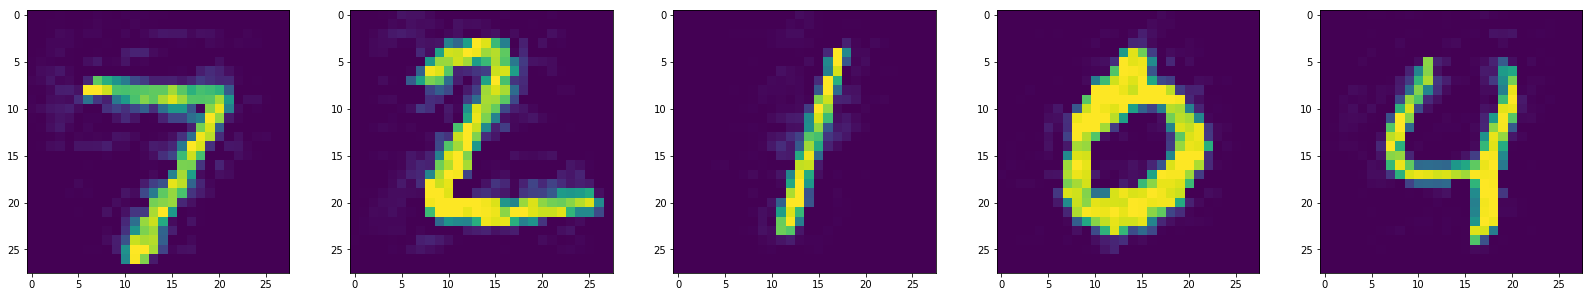

Attacked test data (first 1000 images):
+------+-------+
| True | False |
+======+=======+
| 103  | 897   |
+------+-------+
Accuracy: 10.3%

Prediction time: 1 seconds


In [13]:
number_images = 1000
print("Generate DeepFool attack...")

start = time.time()
#attack = DeepFool(classifier) #if not initialized
#x_test_attack = attack.generate(x_test[:number_images]) #if not initialized
x_test_defend_attack = x_test_attack[:number_images]
print("Attack generated")
end = time.time()
print("\nGeneration time:", int(end - start), "seconds")
show_images(x_test_defend_attack, 0, 4)

start = time.time()
x_test_defend_attack_pred = np.argmax(defence.predict(x_test_defend_attack), axis=1)
correct_defence_attack_pred = np.sum(x_test_defend_attack_pred == np.argmax(y_test[:number_images]))

print("Attacked test data (first", number_images, "images):")

t = Texttable()
t.add_rows([['True', 'False'], [correct_defence_attack_pred, number_images - correct_defence_attack_pred]])
print(t.draw())

acc = round(correct_defence_attack_pred/number_images*100, 4)
print("Accuracy: ", acc, "%", sep='')

end = time.time()
print("\nPrediction time:", int(end - start), "seconds")